# 1. 引入所需套件

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from ipywidgets import interact, FloatSlider, IntSlider, interact_manual

In [4]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics
# Keras datasets
from keras.datasets import mnist
# Keras utilis function
from keras.utils import np_utils
# keras backend
from keras import backend as K

Using TensorFlow backend.


# 2. 匯入資料

In [5]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [6]:
print("There are %d training data with size (%d, %d)" %x_train0.shape)
print("There are %d testing  data with size (%d, %d)" %x_test0.shape)

There are 60000 training data with size (28, 28)
There are 10000 testing  data with size (28, 28)


## 資料預處理

In [7]:
# 調整資料長度
x_train = x_train0.reshape(60000, 784)
x_test = x_test0.reshape(10000, 784)
# 資料歸一化
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min())
x_test = (x_test-x_test.min())/(x_test.max()-x_test.min())

In [8]:
print("There are %d training data with size %d" %x_train.shape)
print("There are %d testing  data with size %d" %x_test.shape)

There are 60000 training data with size 784
There are 10000 testing  data with size 784


# 3. 使用 API 建立網絡

## 定義所需函數(抽樣函數: Sampling, 自定義的loss function: vae_loss)

In [9]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean+K.exp(z_log_var/2)*epsilon

In [10]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## 建立 VAE (內容採上課所建立的)

In [11]:
x = Input(shape=(784,))
# encoding
enc_1 = Dense(100, activation='sigmoid')
enc_x = enc_1(x)
# mean, log_var
enc_mean = Dense(2)
enc_log_var = Dense(2)
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)
# decoding
dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [12]:
# normal sampling layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [13]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [14]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 訓練 VAE

In [15]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=32, epochs=20)

Epoch 1/20
60000/60000 [==============================] - 14s 240us/step - loss: 196.7791
Epoch 2/20
60000/60000 [==============================] - 12s 208us/step - loss: 180.8739
Epoch 3/20
60000/60000 [==============================] - 13s 217us/step - loss: 178.9181
Epoch 4/20
60000/60000 [==============================] - 13s 215us/step - loss: 175.7780
Epoch 5/20
60000/60000 [==============================] - 13s 216us/step - loss: 172.0122
Epoch 6/20
60000/60000 [==============================] - 13s 218us/step - loss: 168.8692
Epoch 7/20
60000/60000 [==============================] - 13s 225us/step - loss: 166.5602
Epoch 8/20
60000/60000 [==============================] - 13s 219us/step - loss: 164.8996
Epoch 9/20
60000/60000 [==============================] - 13s 220us/step - loss: 163.4801
Epoch 10/20
60000/60000 [==============================] - 13s 220us/step - loss: 162.1910
Epoch 11/20
60000/60000 [==============================] - 13s 223us/step - loss: 161.0623
Epoch 12

# 4. VAE 視覺化

## Encoding

In [17]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


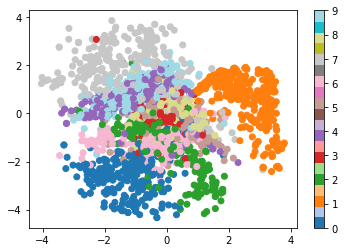

In [18]:
indices = np.random.randint(len(x_test), size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

由encoding二維化的分布圖，可發現0, 1, 2, 7數字分的蠻明顯的。所以看看 decoding 的結果是否也是這樣。

## Decoding

In [19]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [20]:
def normalized(x):
    x = x-x.min()
    x = x/x.max()
    return x

In [21]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [22]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size*n, digit_size*n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1)*digit_size:(n-i)*digit_size, j*digit_size:(j+1)*digit_size] = normalized(digit)

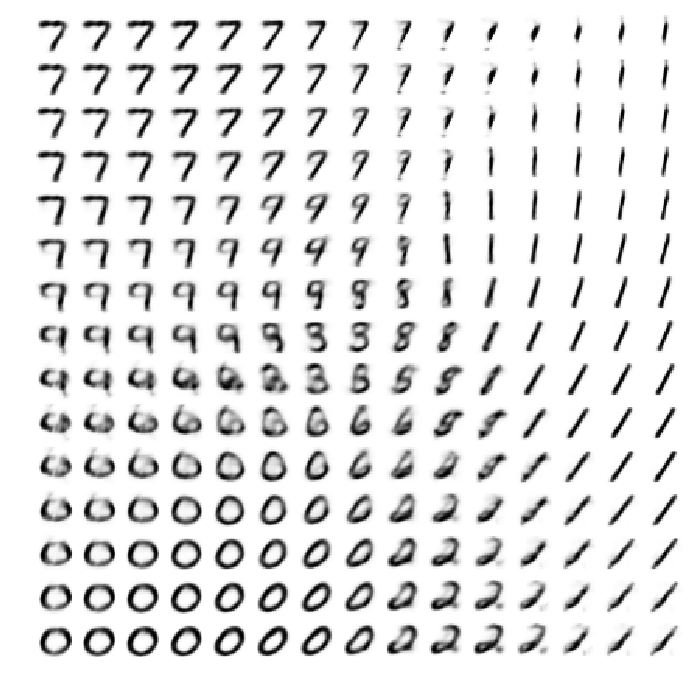

In [23]:
plt.figure(figsize=(12, 12))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

確實，decoding 的結果顯示和 encoding 相似的分布。

# 5. 嘗試製作一個互動式介面(input 兩個數字，顯示上課時助教做出的互動式畫面)

## 輸入兩個數

In [24]:
x = 0
y = 0
while x == y:
    x, y = input("輸入任兩個0 ~ 9數字(ex. 5 9) >> ").split()

輸入任兩個0 ~ 9數字(ex. 5 9) >> 1 1
輸入任兩個0 ~ 9數字(ex. 5 9) >> 1 2


## 從輸入的兩個數中挑選 training data 中的兩張圖片位置

In [25]:
def pick(x, y):
    num1 = int(x)
    num2 = int(y)
    # 從training data 中找出結果為 num1 和 num2 的圖片位置
    num1list = np.where(y_train0 == num1)   
    num2list = np.where(y_train0 == num2)
    # 從 subset1 中挑選一個數字存取
    id1 = np.random.choice(num1list[0])    
    id2 = np.random.choice(num2list[0]) 
    return (id1, id2)

## 建立互動式介面

In [26]:
def inBetween(weight):
    # 找到輸入數字對應的兩張圖片
    data_1 = x_train0[id1]
    data_2 = x_train0[id2]
    data_w = (1-weight)*x_train0[id1] + weight*x_train0[id2]
    # 經過 VAE 後
    mu_0 = VAE_Encoder.predict(x_train[id1:id1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[id2:id2+1]).squeeze()
    mu_w = (1-weight)*mu_0 + weight*mu_1
    # 互動式介面
    plt.figure(figsize=(15, 10))
    ax1 = plt.subplot(2, 3, 1)
    ax1.imshow(data_1, cmap='Greys')
    ax2 = plt.subplot(2, 3, 2)
    ax2.imshow(data_w, cmap='Greys')
    ax3 = plt.subplot(2, 3, 3)
    ax3.imshow(data_2, cmap='Greys')

In [27]:
id1, id2 = pick(x, y)
interact(inBetween, weight=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='weight', max=1.0, step=0.02), Output()), _dom_classe…

<function __main__.inBetween(weight)>